## Project: Plant Seedlings

In this project I build two models based on a tailored made Convolutional Neural Network and a pre-trained model based on the VGG16 model.

Used Dataset from: https://www.kaggle.com/datasets/vbookshelf/v2-plant-seedlings-dataset

The model is trained on food images to distinguish plant seeds divided in 12 classes: Black Grass, Charlock, Cleavers, Common Chickweed, Common Wheat, Fat Hen, Loose Silky Bent, Maize, Scentless Mayweed, Shepherd Purse, Small flowered Cranesbill, and Sugar Beet.

<ul>
    <li>Table of Content
        <ul>
            <li>Download Images</li>
            <li>Build the Model</li>
            <li>Train the Model</li>
            <li>Model Performance</li>
            <li>Report Results</li>
        </ul>
    </li>
    
</ul>

First, we will import important models and the ImageDataGenerator module since we will be leveraging it to train our model in batches.

In [1]:
!python3 --version

Python 3.11.9


In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 

In [3]:
# set a random state number
rs = 42

os.environ['PYTHONHASHSEED']=str(rs)
import random
random.seed(rs)
np.random.seed(rs)


# set the path for the data base containing the images
file_path = "/Users/brncat/Downloads/AltaVerde/GitHub/Dog_Breed_Dataset"

#check existence of the path
if os.path.isdir(file_path):
    print("data set found!")
else:
    raise Exception("data set directory not found!")

data set found!


In [25]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

### Shuffle images from directory into train, valid, and test sets

In [5]:
# Define paths
main_dir = os.path.join(file_path,'main')
train_dir = os.path.join(file_path,'train')
val_dir = os.path.join(file_path,'valid')
test_dir = os.path.join(file_path,'test')

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Ensure ratios sum to 1
assert train_ratio + val_ratio + test_ratio == 1

In [6]:
if os.path.isdir(file_path):
    if os.path.isdir(train_dir):
        print("train dir exist")
    else:
        print("creating train valid test sets")
        # Iterate through each class
        for class_dir in os.listdir(main_dir):
            class_path = os.path.join(main_dir, class_dir)
            if os.path.isdir(class_path):
                # Create train, val, test directories for the class
                os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
                os.makedirs(os.path.join(val_dir, class_dir), exist_ok=True)
                os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
        
                # Get all images in the class directory as a list of strings
                images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        
                # Shuffle and split data
                train_imgs, test_imgs = train_test_split(images, test_size=(1-train_ratio), shuffle=True, 
                                                 random_state=rs)
                val_imgs, test_imgs = train_test_split(test_imgs, test_size=(test_ratio/(val_ratio+test_ratio)), 
                                               shuffle=True,random_state=rs)
        
                # Copy files to corresponding directories
                for img in train_imgs:
                    shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_dir, img))
                for img in val_imgs:
                    shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_dir, img))
                for img in test_imgs:
                    shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_dir, img))
else:
    raise Exception("data set directory not found!")

train dir exist


In [7]:
# Print the count of items from each class

count = 0
for folder in os.listdir(main_dir):
    folder_pics = len(os.listdir(os.path.join(main_dir, folder)))
    print("The", folder, "class has", folder_pics, "pictures.")
    count += folder_pics

print(count,'total images')

The Australian_terrier class has 196 pictures.
The toy_poodle class has 151 pictures.
The Great_Pyrenees class has 213 pictures.
The Maltese_dog class has 252 pictures.
The Norwich_terrier class has 185 pictures.
The whippet class has 187 pictures.
The Boston_bull class has 182 pictures.
The Irish_setter class has 155 pictures.
The Rottweiler class has 152 pictures.
The kelpie class has 153 pictures.
The schipperke class has 154 pictures.
The Leonberg class has 210 pictures.
The Welsh_springer_spaniel class has 150 pictures.
The Pomeranian class has 219 pictures.
The Pekinese class has 149 pictures.
The Irish_wolfhound class has 218 pictures.
The Blenheim_spaniel class has 188 pictures.
The basenji class has 209 pictures.
The African_hunting_dog class has 169 pictures.
The komondor class has 154 pictures.
The Yorkshire_terrier class has 164 pictures.
The basset class has 175 pictures.
The Japanese_spaniel class has 185 pictures.
The standard_schnauzer class has 155 pictures.
The dhole 

## Let us have a look at the classes we are going to classify

In [8]:
# set up a dictionary with {class:image_path} taking a random image from each directory

image_examples_dict = {}
for folder in os.listdir(main_dir):
    pics = random.choice(os.listdir(os.path.join(main_dir, folder)))
    path_pic = os.path.join(main_dir, folder, pics)
    class_pic = folder
    image_examples_dict.update({class_pic: path_pic})

#print(image_examples_dict)

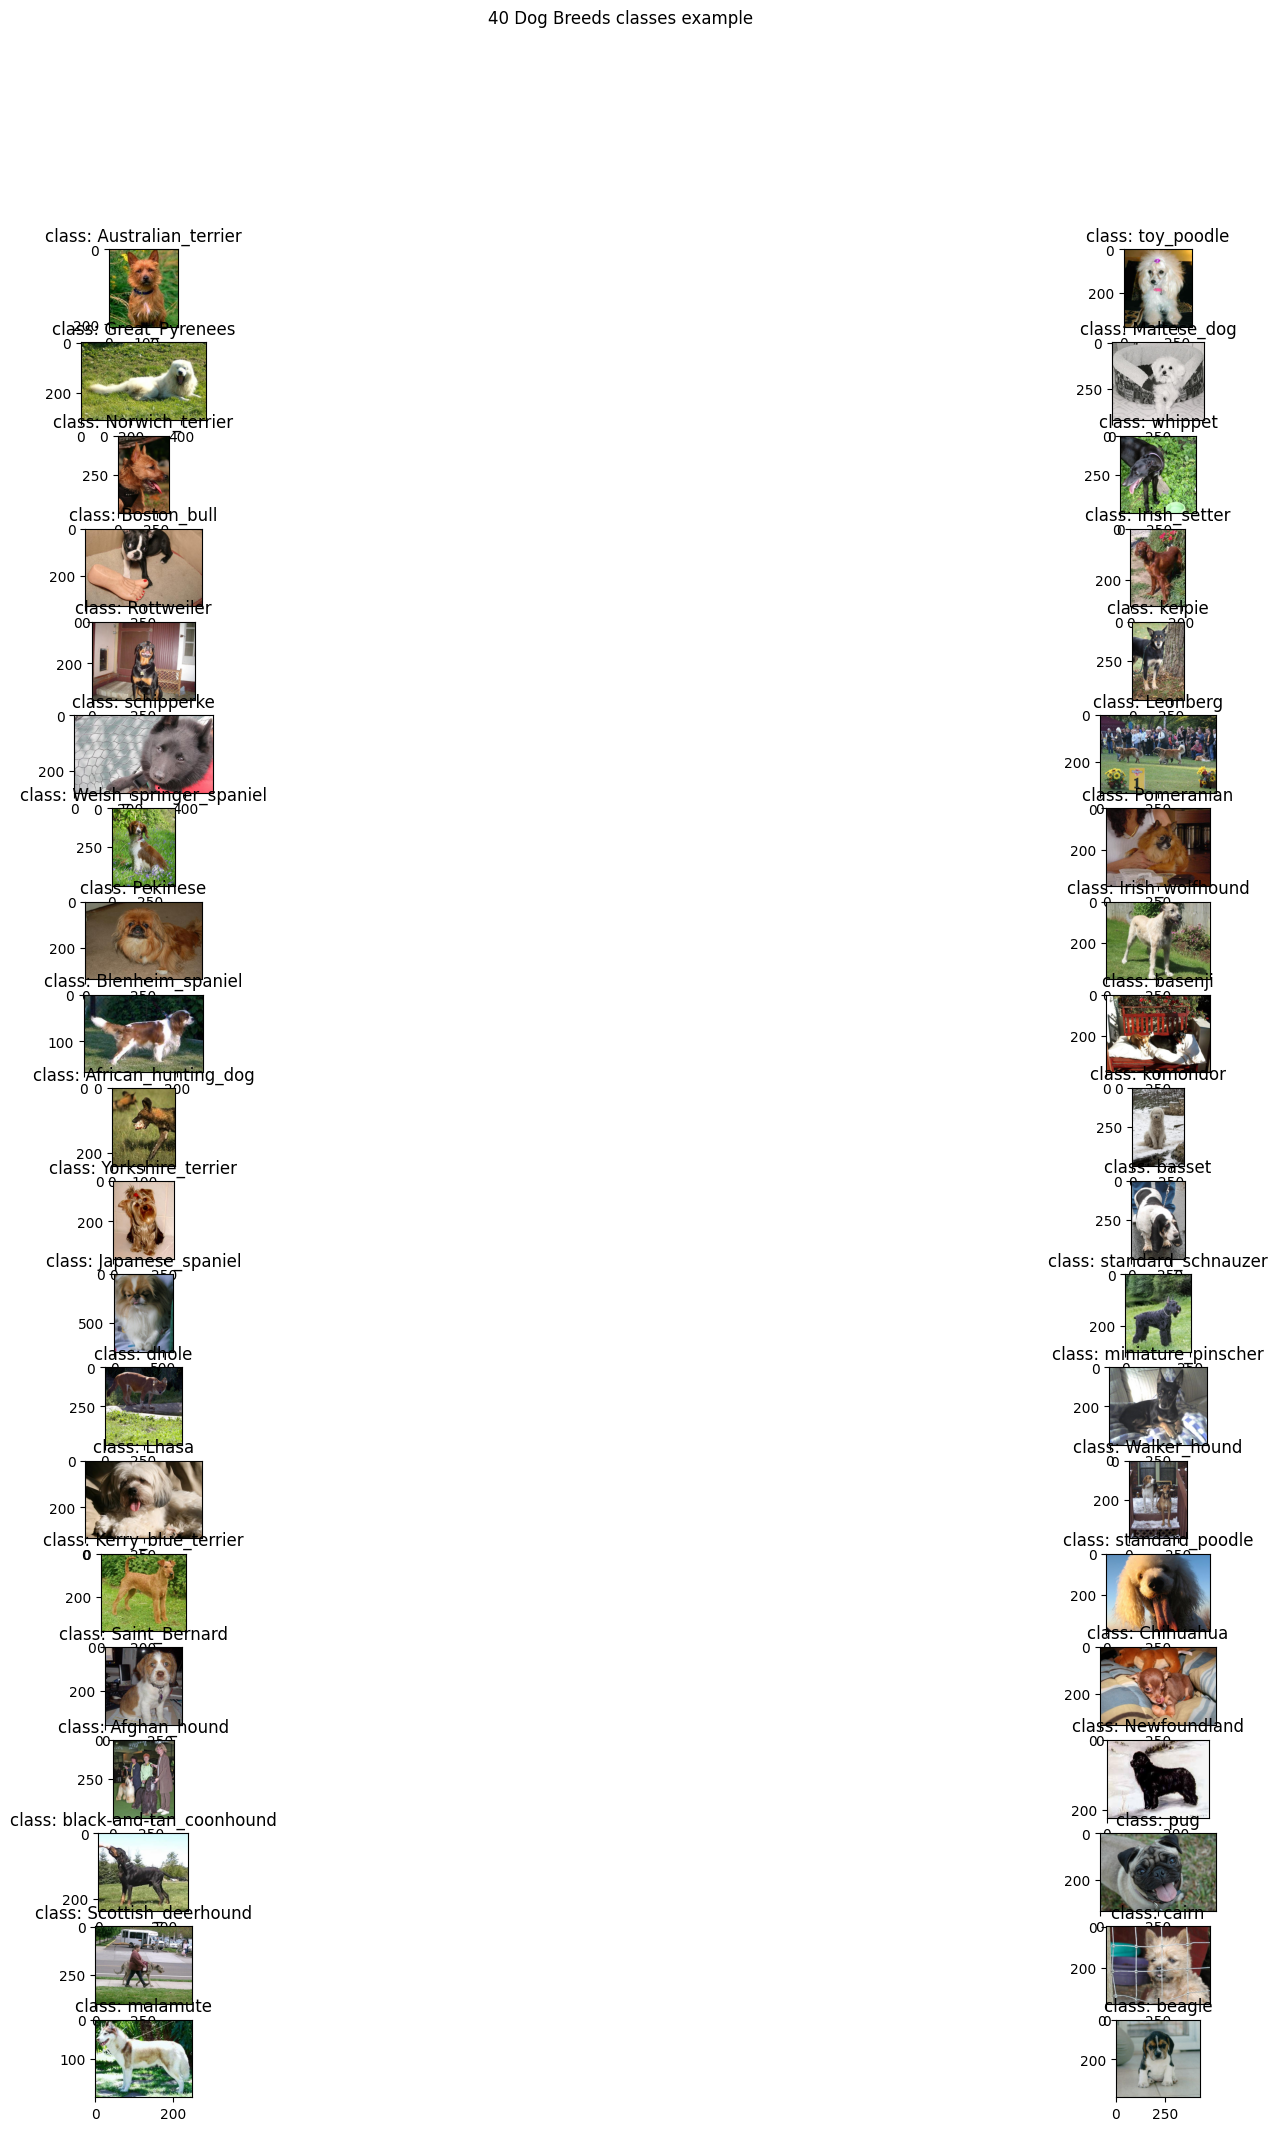

In [9]:
fig, axs = plt.subplots(nrows=20, ncols=2, figsize=(24, 24)) # define your figure and axes

ind = 0
for ax1 in axs:
    for ax2 in ax1:
        batch_image = list(image_examples_dict.items())
        image_data = plt.imread(batch_image[ind][1])
        ax2.imshow(image_data)
        ax2.set_title('class: {}'.format(batch_image[ind][0]))
        ind += 1

fig.suptitle('40 Dog Breeds classes example')
plt.show()

## Model definition


In [10]:
# here I define some important parameter that are going to be used in both models

#num_classes = 

image_resize = 224

batch_size_training = 32
batch_size_validation = 32

num_epochs = 8

In [11]:
# instantiate the image data generator
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

Now we can generate train and validation set with ImageDataGenerator

In [12]:
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical',
    seed=rs
    )

Found 14338 images belonging to 120 classes.


In [13]:
validation_generator = data_generator.flow_from_directory(
    val_dir,
    target_size=(image_resize, image_resize),
    batch_size=batch_size_validation,
    class_mode='categorical',
    seed=rs
)

Found 3097 images belonging to 120 classes.


In [14]:
num_classes = train_generator.num_classes
print("number of automatically found classes: ",num_classes)

number of automatically found classes:  120


In [15]:
class_names = {y: x for x, y in validation_generator.class_indices.items()}
class_names

{0: 'Afghan_hound',
 1: 'African_hunting_dog',
 2: 'Airedale',
 3: 'American_Staffordshire_terrier',
 4: 'Appenzeller',
 5: 'Australian_terrier',
 6: 'Bedlington_terrier',
 7: 'Bernese_mountain_dog',
 8: 'Blenheim_spaniel',
 9: 'Border_collie',
 10: 'Border_terrier',
 11: 'Boston_bull',
 12: 'Bouvier_des_Flandres',
 13: 'Brabancon_griffon',
 14: 'Brittany_spaniel',
 15: 'Cardigan',
 16: 'Chesapeake_Bay_retriever',
 17: 'Chihuahua',
 18: 'Dandie_Dinmont',
 19: 'Doberman',
 20: 'English_foxhound',
 21: 'English_setter',
 22: 'English_springer',
 23: 'EntleBucher',
 24: 'Eskimo_dog',
 25: 'French_bulldog',
 26: 'German_shepherd',
 27: 'German_short-haired_pointer',
 28: 'Gordon_setter',
 29: 'Great_Dane',
 30: 'Great_Pyrenees',
 31: 'Greater_Swiss_Mountain_dog',
 32: 'Ibizan_hound',
 33: 'Irish_setter',
 34: 'Irish_terrier',
 35: 'Irish_water_spaniel',
 36: 'Irish_wolfhound',
 37: 'Italian_greyhound',
 38: 'Japanese_spaniel',
 39: 'Kerry_blue_terrier',
 40: 'Labrador_retriever',
 41: 'Lak

Here we define some optimization parameters that are going to be used with both models.

In [16]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)

print(steps_per_epoch_training,steps_per_epoch_validation)

449 97


## Build the model

### we start with the tailored-made CNN model

In [17]:

def get_model_cnn():
	input = Input(shape=(image_resize,image_resize,3,)) # (None, 224, 224, 3)
	
	conv1  = Conv2D(32,(2,2),activation='relu',padding="same")(input) 
	conv1 = Conv2D(32,(2,2),activation='relu',padding="same")(conv1) 
	pool1  = MaxPooling2D(pool_size=(2,2))(conv1) 
	
	conv2  = Conv2D(64,(3,3),activation='relu',padding="same")(pool1) 
	conv2 = Conv2D(64,(3,3),activation='relu',padding="same")(conv2) 
	pool2  = MaxPooling2D(pool_size=(2,2))(conv2) 
	
	conv3 = Conv2D(128,(3,3),activation='relu',padding="same")(pool2) 
	conv3 = Conv2D(128,(3,3),activation='relu',padding="same")(conv3) 
	pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
	
	conv4 = Conv2D(256,(3,3),activation='relu')(pool3)
	conv4 = Conv2D(256,(3,3),activation='relu')(conv4)
	pool4 = MaxPooling2D(pool_size=(3,3))(conv4)

	conv5 = Conv2D(512,(3,3),activation='relu')(pool4)
	conv5 = Conv2D(512,(3,3),activation='relu')(conv5)
	pool5 = MaxPooling2D(pool_size=(2,2))(conv5) 
	
	flat = Flatten()(pool5) 
	
	drop = Dropout(0.3)(flat) 
	fully = Dense(1024, activation='relu')(drop)  # (None, 512)
	drop = Dropout(0.3)(fully) 
	fully = Dense(1024, activation='relu')(drop) # (None, 512)
	
	pred = Dense(num_classes, activation='softmax')(fully) # (None, 12)
	
	model = Model(inputs=input, outputs=pred)
	
	model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
	
	return model



In [18]:
model_cnn = get_model_cnn()

model_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      416       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      4128      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                             

In [19]:
model_cnn.layers

In [20]:
%%time
start_datetime = datetime.now()

fit_cnn = model_cnn.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose="auto",
)

end_datetime = datetime.now()
print('Training Duration: ' + str(end_datetime-start_datetime))

Epoch 1/8
449/449 [==============================] - 572s 1s/step - loss: 4.7941 - accuracy: 0.0107 - val_loss: 4.7817 - val_accuracy: 0.0116
Epoch 2/8
449/449 [==============================] - 574s 1s/step - loss: 4.7833 - accuracy: 0.0120 - val_loss: 4.7800 - val_accuracy: 0.0123
Epoch 3/8
449/449 [==============================] - 565s 1s/step - loss: 4.7820 - accuracy: 0.0122 - val_loss: 4.7800 - val_accuracy: 0.0123
Epoch 4/8
449/449 [==============================] - 562s 1s/step - loss: 4.7815 - accuracy: 0.0121 - val_loss: 4.7797 - val_accuracy: 0.0123
Epoch 5/8
449/449 [==============================] - 574s 1s/step - loss: 4.7812 - accuracy: 0.0123 - val_loss: 4.7796 - val_accuracy: 0.0123
Epoch 6/8
449/449 [==============================] - 572s 1s/step - loss: 4.7810 - accuracy: 0.0119 - val_loss: 4.7797 - val_accuracy: 0.0123
Epoch 7/8
449/449 [==============================] - 572s 1s/step - loss: 4.7807 - accuracy: 0.0123 - val_loss: 4.7798 - val_accuracy: 0.0123
Epoch 

In [21]:
def save_model(model, model_name):
    """"
    Save the model to a file in the saved_models directory:
    input takes two arguments:
    1: model: keras model object
    2: model_name: string
    """
    model_dir = "../saved_models"
    file_name = os.path.join(model_dir, model_name)

    # check existance of the directory
    if os.path.isdir(model_dir):
        # check existance of the file
        if os.path.isfile(file_name):
            os.remove(file_name)
            model.save(file_name)
            print("model updated")
        else:
            model.save(file_name)
            print("model created")
    else:
        raise Exception("model_dir directory not found")

save_model(model_cnn, "classifier_cnn_model.h5")

model updated


/Users/brncat/Downloads/AltaVerde/GitHub/Dog_Breed_Classifier/notebook/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


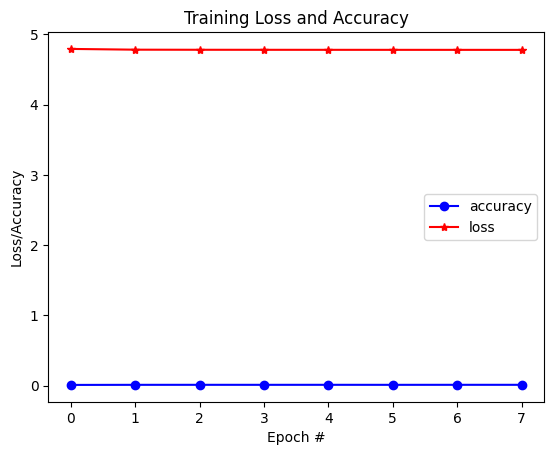

In [22]:
# Model accuracy and loss vs epoch
plt.plot(fit_cnn.history['accuracy'], '-bo', label="accuracy")
plt.plot(fit_cnn.history['loss'], '-r*', label="loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='center right')
plt.show()

# VGG16

## Now that we trained and saved the CNN model, we train a pre-trained model based on the VGG16 model.

In [26]:
def get_model_vgg():

    base_model = VGG16(weights='imagenet', include_top=False) #imports the VGG16 model and discards the last layer.
    x = base_model.output # (None, None, None, 512)
    x = keras.layers.GlobalAveragePooling2D()(x) # (None, 512)

    x = Dropout(0.3)(x) # (None, 512)
    x = Dense(512,activation='relu')(x) # (None, 512)
    x = Dropout(0.3)(x) # (None, 512)

    preds = Dense(num_classes,activation='softmax')(x) #final layer with softmax activation

    model = Model(inputs=base_model.input, outputs=preds)

    #Freeze layers from VGG16 backbone (not to be trained)
    for layer in base_model.layers:
        layer.trainable=False
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [27]:
model_vgg = get_model_vgg()

model_vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [28]:
model_vgg.layers

In [29]:
%%time

start_datetime = datetime.now()

fit_vgg = model_vgg.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose="auto",
)

end_datetime = datetime.now()
print('Training Duration: ' + str(end_datetime-start_datetime))

Epoch 1/8
449/449 [==============================] - 1041s 2s/step - loss: 4.2960 - accuracy: 0.1819 - val_loss: 1.9358 - val_accuracy: 0.5111
Epoch 2/8
449/449 [==============================] - 1065s 2s/step - loss: 2.3321 - accuracy: 0.3938 - val_loss: 1.5501 - val_accuracy: 0.5986
Epoch 3/8
449/449 [==============================] - 1098s 2s/step - loss: 1.9580 - accuracy: 0.4642 - val_loss: 1.3851 - val_accuracy: 0.5977
Epoch 4/8
449/449 [==============================] - 1099s 2s/step - loss: 1.8014 - accuracy: 0.4990 - val_loss: 1.3229 - val_accuracy: 0.6193
Epoch 5/8
449/449 [==============================] - 1062s 2s/step - loss: 1.7117 - accuracy: 0.5202 - val_loss: 1.3073 - val_accuracy: 0.6261
Epoch 6/8
449/449 [==============================] - 1060s 2s/step - loss: 1.6401 - accuracy: 0.5351 - val_loss: 1.2693 - val_accuracy: 0.6348
Epoch 7/8
449/449 [==============================] - 1103s 2s/step - loss: 1.5644 - accuracy: 0.5491 - val_loss: 1.2995 - val_accuracy: 0.6225

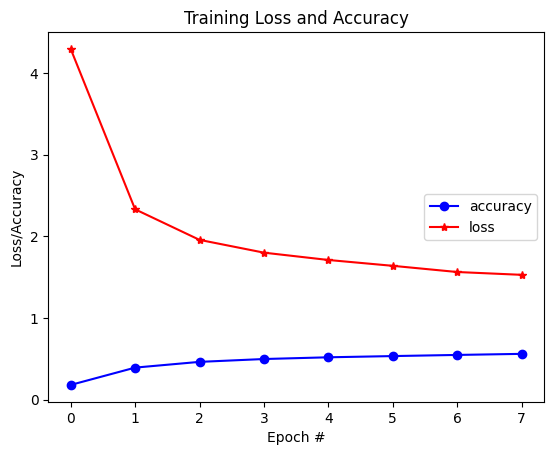

In [30]:
# Model accuracy and loss vs epoch
# Model accuracy and loss vs epoch
plt.plot(fit_vgg.history['accuracy'], '-bo', label="accuracy")
plt.plot(fit_vgg.history['loss'], '-r*', label="loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='center right')
plt.show()

In [31]:
# Save the model to a file
save_model(model_vgg, "classifier_vgg_model.h5")

model created


#  Persist the models and evaluate on the test set

In [32]:
# also run the first two cells to define file path and ramdom state 

from keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg16 import preprocess_input

from keras.models import load_model

In this step we load the saved models and evaluate them on the test set

In [ ]:
!ls 

notebook.ipynb   requirements.txt


In [33]:
# instantiate image data generator
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

image_resize = 224

test_dir = os.path.join(file_path,'test')

#check existence of the path
if os.path.isdir(test_dir):
    print("test set found!")
else:
    raise Exception("test set directory not found!")

test set found!


In [34]:
test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(image_resize, image_resize),
    shuffle=True,
    batch_size = 1,
    class_mode='categorical',
    seed=rs
)

Found 3145 images belonging to 120 classes.


In [35]:
print(test_generator.batch_size)

1


In [36]:
class_names = {y: x for x, y in test_generator.class_indices.items()}
class_names

{0: 'Afghan_hound',
 1: 'African_hunting_dog',
 2: 'Airedale',
 3: 'American_Staffordshire_terrier',
 4: 'Appenzeller',
 5: 'Australian_terrier',
 6: 'Bedlington_terrier',
 7: 'Bernese_mountain_dog',
 8: 'Blenheim_spaniel',
 9: 'Border_collie',
 10: 'Border_terrier',
 11: 'Boston_bull',
 12: 'Bouvier_des_Flandres',
 13: 'Brabancon_griffon',
 14: 'Brittany_spaniel',
 15: 'Cardigan',
 16: 'Chesapeake_Bay_retriever',
 17: 'Chihuahua',
 18: 'Dandie_Dinmont',
 19: 'Doberman',
 20: 'English_foxhound',
 21: 'English_setter',
 22: 'English_springer',
 23: 'EntleBucher',
 24: 'Eskimo_dog',
 25: 'French_bulldog',
 26: 'German_shepherd',
 27: 'German_short-haired_pointer',
 28: 'Gordon_setter',
 29: 'Great_Dane',
 30: 'Great_Pyrenees',
 31: 'Greater_Swiss_Mountain_dog',
 32: 'Ibizan_hound',
 33: 'Irish_setter',
 34: 'Irish_terrier',
 35: 'Irish_water_spaniel',
 36: 'Irish_wolfhound',
 37: 'Italian_greyhound',
 38: 'Japanese_spaniel',
 39: 'Kerry_blue_terrier',
 40: 'Labrador_retriever',
 41: 'Lak

In [37]:
# load the models

model_cnn = load_model('../saved_models/classifier_cnn_model.h5')

model_vgg = load_model('../saved_models/classifier_vgg_model.h5')

In [38]:
# Evaluate CNN on test_generator

test_generator.reset()
eval_cnn = model_cnn.evaluate(test_generator)
print('CNN Test loss: ', eval_cnn[0])
print('CNN Test Accuracy: ', eval_cnn[1])

3145/3145 [==============================] - 56s 18ms/step - loss: 4.7794 - accuracy: 0.0121
CNN Test loss:  4.779356956481934
CNN Test Accuracy:  0.01208267081528902


In [39]:
# Evaluate pre-trained model on test_generator

test_generator.reset()
eval_vgg = model_vgg.evaluate(test_generator)
print('VGG Test loss: ', eval_vgg[0])
print('VGG Test Accuracy: ', eval_vgg[1])

3145/3145 [==============================] - 245s 78ms/step - loss: 1.2086 - accuracy: 0.6502
VGG Test loss:  1.2085509300231934
VGG Test Accuracy:  0.6502384543418884


## Plot the Confusion Matrix

### We see that the VGG16 pre-trained model performs better than our defined CNN model.

Although the VGG16 model performs slightly better than our CNN model on the test set, we prefer our CNN due to its shorter training time and smaller size.